In [1]:
import os # Configure which GPU 
#import sys
import torch
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

no_preview = True

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from sionna.mimo.precoding import normalize_precoding_power, grid_of_beams_dft
from sionna.rt import visualize 
import math

In [3]:
def find_cell_index(user_pos, cell_centers, cell_size):
    num_users = user_pos.shape[0]
    cell_zero_pos_x = cell_centers[0,0,0]
    cell_zero_pos_y = cell_centers[0,0,1]
    del_x = cell_size[0]
    del_y = cell_size[1]

    cell_index_x = []
    cell_index_y = []
    distance = []
    
    for user in range(num_users):
        
        user_pos_x = user_pos[user, 0]
        user_pos_y = user_pos[user, 1]
        x_index = tf.math.floor(((user_pos_x - cell_zero_pos_x)-del_x/2)/del_x +1)
        y_index = tf.math.floor(((user_pos_y - cell_zero_pos_y)-del_y/2)/del_y +1)
        cell_index_x.append(int(x_index))
        cell_index_y.append(int(y_index))
        cell_x = cell_centers[int(y_index), int(x_index), 0]
        cell_y = cell_centers[int(y_index), int(x_index), 1]
        dd = tf.math.sqrt((cell_x-user_pos_x)*(cell_x-user_pos_x) + (cell_y-user_pos_y)*(cell_y-user_pos_y))
        distance.append(dd)
    return cell_index_x, cell_index_y, distance

def calculate_cover(coveragemap_list, txpow, threshold, limitarea = True, ar_begin = 40,  ar_end = 200, col_begin = 50, col_end = 250):
    # calculate the signal strength of the map and comparing to threshold
    map = np.zeros_like(coveragemap_list[0], dtype=bool)
    # print("111111111")
    # print(coveragemap_list[0])
    mapp = 10.*np.log10(coveragemap_list[0])
    mapp = (mapp+txpow > threshold)
    map = np.logical_or(map, mapp)
    if limitarea:
        map = map[ar_begin:ar_end, col_begin:col_end]
    return map


def config_scene(scene, num_rows, num_cols, pattern, bs_pwr, tx_pos, look_at = [0,0,0]):
    # Configure planar arrays for all TX and RX
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern=pattern,
                                 polarization="V")

    scene.rx_array = PlanarArray(num_rows=2,
                                 num_cols=2,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")
    # print(scene.tx_array.num_ant)

    scene.remove('tx')
    scene.add(Transmitter(name='tx',
                          position= tx_pos,
                          look_at= look_at,
                          power_dbm = bs_pwr))
    return scene

def compute_cm(scene):
    cm = scene.coverage_map(
        max_depth=5,
        diffraction=True, # Disable to see the effects of diffraction
        cm_cell_size=(5., 5.), # Grid size of coverage map cells in m
        combining_vec=None,
        precoding_vec=None,
        num_samples=int(10e6) # Reduce if your hardware does not have enough memory
    )
    return cm

def return_geoidx(pslist):
    x0 = -805.583664
    y0 = -688.600626
    del_x = 5
    del_y = 5
    x, y = pslist[:2]
    x_idx = np.round((x-x0)/del_x)
    y_idx = np.round((y-y0)/del_y)
    return int(x_idx),int(y_idx)

def calculate_sinr_performance(coveragemap, uebaseline_map, txpow, threshold):
    cm_map = 10.*np.log10(coveragemap[0])
    ue_map = 10.*np.log10(uebaseline_map[0])
    cm_map = (cm_map > threshold)
    ue_map = (ue_map > threshold)
    mapp = np.logical_or(cm_map, ue_map)
    
    num_lightup_blocks = np.sum(mapp)
    num_baseline_blocks = np.sum(ue_map)
    return num_lightup_blocks, num_baseline_blocks

def calculate_sinr(coveragemap_list, txpow, threshold):
    # calculate the signal strength of the map and comparing to threshold
    map = np.zeros_like(coveragemap_list[0], dtype=bool)
    mapp = 10.*np.log10(coveragemap_list[0])
    mapp = (mapp > threshold)
    map = np.logical_or(map, mapp)
    num_lightup_blocks = np.sum(map)
    return map, num_lightup_blocks

def calculate_sinr_testing(coveragemap_list, threshold):
    # print(coveragemap_list)
    mapp = 10.*np.log10(coveragemap_list[0])
    mapp = (mapp > threshold)
    num_lightup_blocks = np.sum(mapp)
    return mapp, num_lightup_blocks

def calculate_db_snr_all(user_pos, cell_centers, cell_size, coveragemap_tensor):
    index_x, index_y, distance = find_cell_index(user_pos, cell_centers, cell_size)
    num_users = len(index_x)
    num_iteration = 0
    snrs = 0
    for user in range(num_users):
        if coveragemap_tensor[0, index_y[user], index_x[user]].numpy() == 0:
            continue
        snrs = snrs + coveragemap_tensor[0, index_y[user], index_x[user]].numpy()
        num_iteration += 1
    return snrs/num_iteration
    

{1: 10.0, 2: 6.989700043360188, 4: 3.979400086720376, 8: 0.9691001300805642, 16: -2.041199826559248}
[-507.75528564 -477.75528564 -447.75528564 -417.75528564 -387.75528564
 -357.75528564 -327.75528564 -297.75528564 -267.75528564 -237.75528564
 -207.75528564 -177.75528564 -147.75528564 -117.75528564  -87.75528564
  -57.75528564  -27.75528564    2.24471436   32.24471436   62.24471436
   92.24471436  122.24471436  152.24471436  182.24471436  212.24471436
  242.24471436  272.24471436  302.24471436  332.24471436  362.24471436]


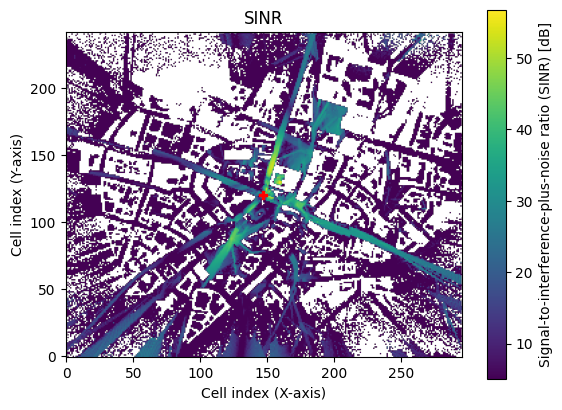

In [4]:
# Finding the power for each case
def divide_power_dBm(P_dBm, N_list):
    P_linear = 10**(P_dBm / 10)  # Convert dBm to linear power
    power_dict = {N: 10 * np.log10(P_linear / N) for N in N_list}  # Store in dictionary
    return power_dict

P = 10
N_values = [1, 2, 4, 8, 16]
Pw_maps = divide_power_dBm(P, N_values)
print(Pw_maps)


# loading scene
sn = load_scene(sionna.rt.scene.munich)

# finding scene paramters
x_factor = 0.7
y_factor = 0.7
scene_x_length = sn.size[0].numpy() * x_factor
scene_y_length = sn.size[1].numpy() * y_factor
scene_center_x = sn.center[0].numpy()
scene_center_y = sn.center[1].numpy()
start_x = scene_center_x - (scene_x_length/2)
start_y = scene_center_y - (scene_y_length/2)

y_grid = np.arange(start_y, start_y + scene_y_length + 30, 30)
print(y_grid)

tx_height = 50
scene_1tx_64ant= config_scene(sn, 8, 8, 'dipole', Pw_maps[1], [scene_center_x, scene_center_y, tx_height])

cm_1tx_64ant = compute_cm(scene_1tx_64ant)

im1 = cm_1tx_64ant.show(metric = "sinr", vmin = 5)

In [5]:
def generate_tx_positions(myscene, tx_height = 49.285, x_points = 100, y_points = 100, x_factor = 0.7, y_factor = 0.7):
    # this function take the scene as input and give you the tx positions as a numpy array 2d as follows: 
    # positionlist =  np.array(
    #                 [[-67.850464, -85.782776,  49.285 ],
    #                  [-67.850464, -85.782776,  49.285 ],
    #                  [-67.850464, -85.782776,  49.285 ],
    #                  [-67.850464, -85.782776,  49.285 ],
    #                  [-67.850464, -85.782776,  49.285 ]])
    # since the simulation on the edge of the map would not be accurate, we only put the txs at the center part of the scene
    # x_factor and y_factor are used to tune how much area in x and y diractions we place the tx
    scene_x_length = myscene.size[0].numpy() * x_factor
    scene_y_length = myscene.size[1].numpy() * y_factor
    scene_center_x = myscene.center[0].numpy()
    scene_center_y = myscene.center[1].numpy()
    start_x = scene_center_x - scene_x_length/2
    start_y = scene_center_y - scene_y_length/2
    x_array = np.linspace(start_x, start_x + scene_x_length, x_points)
    y_array = np.linspace(start_y, start_y + scene_y_length, y_points)

    tx_positions = np.empty((0,3), dtype=np.float32)
    for i in range(len(x_array)):
        for j in range(len(y_array)):
            array_temp = np.array([x_array[i], y_array[j], tx_height])
            tx_positions = np.vstack((tx_positions, array_temp))
    return tx_positions, x_array, y_array
    
TX_height = 20

# print(sn.size[0])
tx_positions, x_array, y_array = generate_tx_positions(sn, tx_height = TX_height, 
                                                       x_points = 1, y_points = 2, x_factor = 0, y_factor = 0.1)
print(tx_positions)

[[ -67.85046387 -146.06456299   20.        ]
 [ -67.85046387  -25.50098877   20.        ]]


In [6]:
# 2 Transmitters

scene2 = load_scene(sionna.rt.scene.munich)

# Scene setup
scene2.bandwidth=100e6
scene2.frequency = 2.14e9
scene2.synthetic_array = True
x = []
y = []
sinr_TH = 5

coverage_TX1 = {}
coverage_TX2 = {}

look_at_pos, _ , _ = generate_tx_positions(sn, tx_height = TX_height, x_points = 5, y_points = 5, x_factor = 0.7, y_factor = 0.7)
# print(look_at_pos)
look_at_dict = {}
for i, look_at in enumerate(look_at_pos):
    look_at_dict[i] = look_at
print(look_at_dict)

for i, pos in enumerate(tx_positions):
    print(pos)
    for j, look_at in enumerate(look_at_pos):
        print(look_at)
        scene2 = config_scene(scene2, 4, 8, 'dipole', Pw_maps[2], pos, look_at)
        cm2 = compute_cm(scene2)
        # cm2.show(metric = "rss")
        sinr_cover, number_lightup_blk = calculate_sinr_testing(cm2.sinr, sinr_TH)
        print(number_lightup_blk)
        if(i == 0):
            coverage_TX1[j] = sinr_cover
        else:
            coverage_TX2[j] = sinr_cover

{0: array([-584.2637146 , -507.75528564,   20.        ]), 1: array([-584.2637146 , -296.76903076,   20.        ]), 2: array([-584.2637146 ,  -85.78277588,   20.        ]), 3: array([-584.2637146,  125.203479 ,   20.       ]), 4: array([-584.2637146 ,  336.18973389,   20.        ]), 5: array([-326.05708923, -507.75528564,   20.        ]), 6: array([-326.05708923, -296.76903076,   20.        ]), 7: array([-326.05708923,  -85.78277588,   20.        ]), 8: array([-326.05708923,  125.203479  ,   20.        ]), 9: array([-326.05708923,  336.18973389,   20.        ]), 10: array([ -67.85046387, -507.75528564,   20.        ]), 11: array([ -67.85046387, -296.76903076,   20.        ]), 12: array([-67.85046387, -85.78277588,  20.        ]), 13: array([-67.85046387, 125.203479  ,  20.        ]), 14: array([-67.85046387, 336.18973389,  20.        ]), 15: array([ 190.3561615 , -507.75528564,   20.        ]), 16: array([ 190.3561615 , -296.76903076,   20.        ]), 17: array([190.3561615 , -85.782775

/var/folders/t6/hxv194_11rnb1z4tn9q6s56r0000gn/T/ipykernel_24172/753904671.py:106: RuntimeWarning: divide by zero encountered in log10
  mapp = 10.*np.log10(coveragemap_list[0])


1200
[-584.2637146  -296.76903076   20.        ]
1012
[-584.2637146   -85.78277588   20.        ]
587
[-584.2637146  125.203479    20.       ]
823
[-584.2637146   336.18973389   20.        ]
1134
[-326.05708923 -507.75528564   20.        ]
1122
[-326.05708923 -296.76903076   20.        ]
1144
[-326.05708923  -85.78277588   20.        ]
578
[-326.05708923  125.203479     20.        ]
1036
[-326.05708923  336.18973389   20.        ]
711
[ -67.85046387 -507.75528564   20.        ]
814
[ -67.85046387 -296.76903076   20.        ]
816
[-67.85046387 -85.78277588  20.        ]
816
[-67.85046387 125.203479    20.        ]
809
[-67.85046387 336.18973389  20.        ]
813
[ 190.3561615  -507.75528564   20.        ]
752
[ 190.3561615  -296.76903076   20.        ]
904
[190.3561615  -85.78277588  20.        ]
933
[190.3561615 125.203479   20.       ]
1217
[190.3561615  336.18973389  20.        ]
1148
[ 448.56278687 -507.75528564   20.        ]
1016
[ 448.56278687 -296.76903076   20.        ]
649
[44

Best location with maximum overlap: (array([448.56278687, 336.18973389,  20.        ]), array([-326.05708923, -507.75528564,   20.        ])) with 1424 overlap blocks
148 109


/var/folders/t6/hxv194_11rnb1z4tn9q6s56r0000gn/T/ipykernel_24172/753904671.py:106: RuntimeWarning: divide by zero encountered in log10
  mapp = 10.*np.log10(coveragemap_list[0])


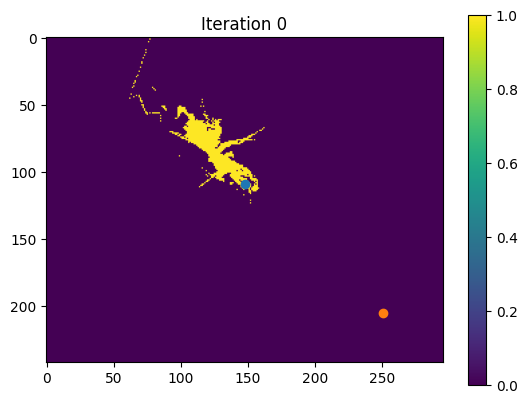

148 133


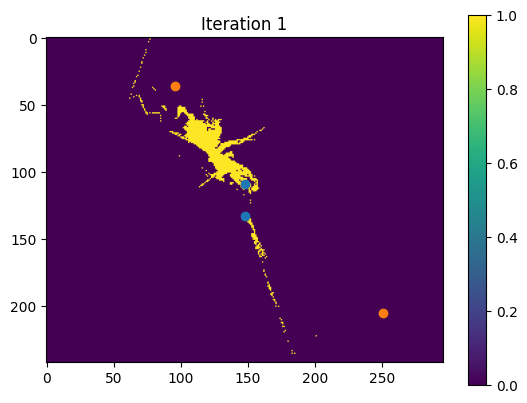

In [7]:
def return_geoidx2(pslist):
    x0 = -805.583664
    y0 = -688.600626
    del_x = 5
    del_y = 5
    x, y = pslist[:2]
    x_idx = np.round((x-x0)/del_x)
    y_idx = np.round((y-y0)/del_y)
    return int(x_idx),int(y_idx)

def compare_sinr_performance(cm_map1, cm_map2):
    overlap_map = np.logical_or(cm_map1, cm_map2)
    num_overlap_blocks = np.sum(overlap_map)
    return overlap_map, num_overlap_blocks
    
max_overlap = float('-inf')
best_location = (None, None)
optimal_map = 0

for key1, val1 in coverage_TX1.items():
    for key2, val2 in coverage_TX2.items():
        overlap_map, num_overlap_blocks_temp = compare_sinr_performance(val1, val2)
        # print(key1, key2, num_overlap_blocks_temp)
        if num_overlap_blocks_temp > max_overlap:
            max_overlap = num_overlap_blocks_temp
            optimal_map = overlap_map
            best_location = (look_at_dict[key1], look_at_dict[key2])
        
print("Best location with maximum overlap:", best_location, "with", max_overlap, "overlap blocks")

sn2 = load_scene(sionna.rt.scene.munich)

# Scene setup
sn2.bandwidth=100e6
sn2.frequency = 2.14e9
sn2.synthetic_array = False
x = []
y = []
rss_TH = -100
sinr_TH = 5

# Without interference
x_theory = []
y_theory = []
sinr_cover = 0
for i, tx_pos in enumerate(tx_positions):
    plt.figure()
    x_temp,y_temp = return_geoidx2(tx_pos)
    print(x_temp, y_temp)
    x_theory.append(x_temp)
    y_theory.append(y_temp)
    x_look, y_look = return_geoidx2(best_location[i])
    x.append(x_look)
    y.append(y_look)
    
    sn_2tx = config_scene(sn2, 4, 8, 'dipole', Pw_maps[2], tx_pos, best_location[i])
    cm_2tx = compute_cm(sn_2tx)
    
    sinr_cover_temp, number_lightup_blk = calculate_sinr_testing(cm_2tx.sinr, sinr_TH)
    sinr_cover, num_overlap_blocks_temp = compare_sinr_performance(sinr_cover, sinr_cover_temp)

    plt.scatter(x_theory, y_theory)
    plt.scatter(x, y)
    plt.imshow(sinr_cover, cmap='viridis')
    plt.title(f"Iteration {i}")
    plt.colorbar()  # Optional: add a colorbar to indicate SINR scale
    plt.show()

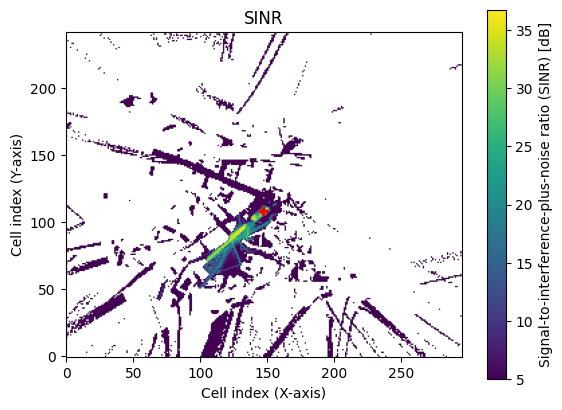

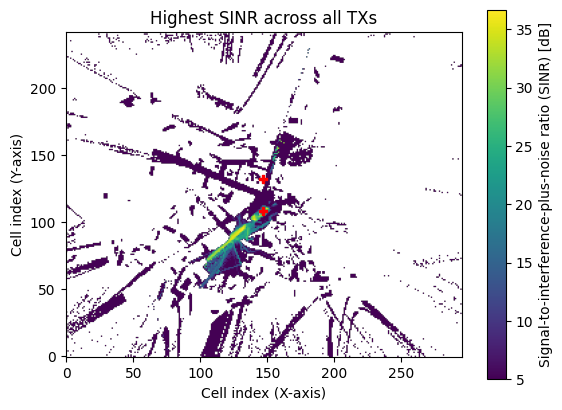

In [8]:
def config_scene_MISO(scene, num_rows, num_cols, pattern, bs_pwr, tx_pos, iter_num, look_at = [0,0,0]):
    # scene = load_scene(sionna.rt.scene.munich)
    
    scene.bandwidth=100e6
    scene.frequency = 2.14e9
    scene.synthetic_array = True
    
    # Configure planar arrays for all TX and RX
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern=pattern,
                                 polarization="V")

    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")
    
    scene.add(Transmitter(name=f'tx{iter_num}',
                          position= tx_pos,
                          look_at= look_at,
                          power_dbm = bs_pwr))
    return scene


scene2 = load_scene(sionna.rt.scene.munich)

sinr_TH = 5

# actual coverage
for i, tx_pos in enumerate(tx_positions):
    sn_2tx_real = config_scene_MISO(scene2, 4, 8, 'dipole', Pw_maps[2], tx_pos, i, best_location[i])
    cm_2tx_real = compute_cm(sn_2tx_real)
    cm_2tx_real.show(metric = "sinr",vmin=5)

# im = cm_2tx_real.show(metric = "sinr")

Maximum SNR in the map:  36.666016
Blocks above the threshold:  1043


/var/folders/t6/hxv194_11rnb1z4tn9q6s56r0000gn/T/ipykernel_24172/692538445.py:8: RuntimeWarning: divide by zero encountered in log10
  snr_db = 10 * np.log10(snr_linear)


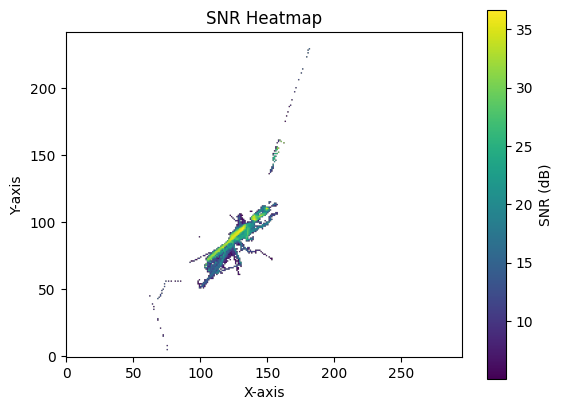

In [9]:
def my_snr(rss_map, scene):
    sum_rss = np.sum(rss_map, axis=0)
    # Get thermal noise power
    noise = scene.thermal_noise_power
    # Compute linear SNR
    snr_linear = sum_rss / noise
    # convert snr from linear to dB
    snr_db = 10 * np.log10(snr_linear)
    snr_db[snr_db < 5] = np.nan
    max_snr = np.nanmax(snr_db)
    blocks_above_threshold = np.sum(~np.isnan(snr_db))
    return snr_db, max_snr, blocks_above_threshold
    
def plot_snr_map(cmapp):
    # Create a heatmap
    # cmappp = cmapp[0]
    plt.imshow(cmapp, cmap='viridis',  origin='lower')
    plt.colorbar(label="SNR (dB)")
    plt.title("SNR Heatmap")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()
    
snr, max_snr, blocks = my_snr(cm_2tx_real.rss, scene2)
print("Maximum SNR in the map: ", max_snr)
print("Blocks above the threshold: ", blocks)
plot_snr_map(snr)

In [10]:
scene2.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …